# **<p style="color:red;">PYNQ FFT Exercise**

![start](../images/prologue.png)

---

# *How to build a hardware FFT accelerator*

### Execute all of the following cells, fill in empty cells if instructed.

##  Determine what you would like to compute

In this case it has been determined we would like as fast as possible float precision FFT computation up to length 32768 

## Benchmark the Python software

Import libraries and modules:

In [1]:
import numpy as np
import random
from pynq import Overlay
import axitimer
max_fft_N = 12 # Logic and DMA max for simple mode on ARM32 is 4096 complex 32-bit elements

Load the FFT Overlay and allow axitimer to bind to it:

In [2]:
ol = Overlay('/home/xilinx/jupyter_notebooks/professional_pynq/dsp_class/fft.bit')

In [3]:
ol?

Use Numpy 'complex64' type arrays and establish some test bench data to use when comparing results and performance.

In [4]:
tmr = ol.axi_timer_0
tmr.start_tmr()
sw_fft_times = []
for i in range(6,max_fft_N+1):
    swt = 0
    size = 2 ** i
    din = np.empty(shape=(size,), dtype='complex64')
    din.imag[0:size] = np.random.rand(size,)
    din.real[0:size] = np.random.rand(size,)
    din[20] = 1.0;
    for n in range(0,100):
        start = tmr.read_count()
        dout_sw = np.fft.fftn(din)
        end = tmr.read_count()
        swt += tmr.time_it(start,end)
    sw_fft_times.append([size, 1000*swt/(n+1)])
print('[size, Time in mS]')
print(sw_fft_times)

[size, Time in mS]
[[64, 0.08094232942329421], [128, 0.08678866788667884], [256, 0.09567923679236788], [512, 0.11658432584325842], [1024, 0.1621756217562175], [2048, 0.28429216292162923], [4096, 0.5966666866668667]]


## Create some Python to help with bitpacking the hardware FFT control words

In [5]:
def bits_to_bytes(bit_str, base=2, byteorder='big') :
    nbytes = int(len(bit_str) * .125 + .9) if base == 2 else int(len(bit_str) * .5 + .9) if base == 16 else 0  
    return int(bit_str, base=base).to_bytes(nbytes, byteorder=byteorder)

def bytes_to_uint32s(byte_s) :
    assert type(byte_s) == bytes, RuntimeError
    return [int.from_bytes(byte_s[i:i+4], byteorder='big') for i in range(0,len(byte_s),4)]

def create_config_tdata(N, fwd_inv=True):
    assert N > 2 and N < 13, RuntimeError
    N = int(N)
    NFFT = N.to_bytes(1, byteorder='big')            # Must be padded to byte
    CP_LEN = ''                                      # padded but unused for this FFT config
    FWD_INV = '0b1' if fwd_inv == True else '0b0'    # No padding
    SCALE_SCH = ''                                   # padded but unused for this FFT config
    return bytes_to_uint32s(bits_to_bytes(FWD_INV) + NFFT) # Final result needs padded to 8 bits worth and converted into 32-bit words for AXI

## Configure the hardware FFT

In [6]:
# The constraints say it should work up to about 150MHz
from pynq import Clocks

In [8]:
from axififo import FifoStreamDriver
ol = Overlay('/home/xilinx/jupyter_notebooks/professional_pynq/dsp_class/fft.bit', download=False)
cfg_data = create_config_tdata(max_fft_N, True)
fft_cfg = ol.axi_fifo_mm_s_0
fft_cfg.send_tx_pkt(cfg_data)

##  Send and receive data to the hardware FFT using DMA


The FFT has an AXI streaming interface connected to a dual channel DMA IP Block (see diagram above).  The FFT block consumes a length setting worth of 'complex64'
1. import axidma.py to use the module's 'SimpleDmaDriver' class to write and read data to the hardware FFT accelerator
1. reload the Overlay to bind 'SimpleDmaDriver'
1. optionally create alias for the Overlay's 'SimpleDmaDriver'
1. establish proper SimpleDmaDriver.txbuf size and data type by using SimpleDmaDriver.resize_bufs(4096, data_type='complex64')
1. copy the data into the SimpleDmaDriver.txbuf[0:size] member, you could use 'din' from prior cells or create new values directly into txbuf
1. send data with SimpleDmaDriver.send_dma()
1. receive data with SimpleDmaDriver.rcv_dma()
1. the data from the FFT output will be received into SimpleDmaDriver.rxbuf
1. display the values of rxbuf
1. compare the execution timing results with Numpy's FFT (use the same input data for Numpy as you input to the hardware FFT) 

In [9]:
import axidma
ol = Overlay('/home/xilinx/jupyter_notebooks/professional_pynq/dsp_class/fft.bit', download=False)
fft = ol.axi_dma_0
fft.resize_bufs(shape=[size,], dtype='complex64')
fft.txbuf[0:size] = din
fft.send_dma()
fft.rcv_dma()
fft.rxbuf

PynqBuffer([2060.9058   +2.0091859e+03j,   17.833496 -7.6325836e+00j,
             -45.187958 -1.3804245e+01j, ...,  -10.380432 -2.6077286e+01j,
              -7.6701508+5.9860229e-01j,   11.799591 +5.4680435e+01j],
           dtype=complex64)

In [10]:
np.fft.fftn(din)

array([2060.90585074+2.00918597e+03j,   17.83354991-7.63254124e+00j,
        -45.18789863-1.38042133e+01j, ...,  -10.38040273-2.60772412e+01j,
         -7.67012494+5.98658556e-01j,   11.79961908+5.46804894e+01j])

mean squared error: 1.6433654613559282e-10


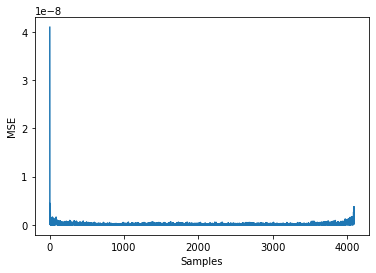

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
hw_fft_data = np.abs(np.array(fft.rxbuf))
sw_fft_data = np.abs(np.array(np.fft.fftn(din)))
err_squared = (hw_fft_data-sw_fft_data)**2
f, ax = plt.subplots()
ax.plot(err_squared)
ax.set_xlabel('Samples')
ax.set_ylabel('MSE');
print('mean squared error: ' + str(err_squared.mean()))

### Do the results match exactly or are they just close?

## Benchmarking: copy DMA driver FFT vs. Numpy FFT

The custom DMA driver in axidma.py has 2 methods to read and write data with DMA. The 1st method 'send_cpy()' and 'rcv_cpy()' is convenient, just pass in a list of data and the method handles all the details including the allocate type buffers.  Along the way it makes a copy of the data however.  The 2nd method 'send_dma()' and 'rcv_dma()' requires pre-sizing built in 'rxbuf' and 'txbuf' buffers and loading the data into those buffers. This eliminates a copy each time and type allocate buffer allocation and free.

1. use the example from the beginning but enhance it to use both the hardware and software versions of the FFT
1. use the SimpleDmaDriver.send_cpy() and .rcv_cpy() methods
1. enhance it to use the AXI hardware timer for measurement
    1. use the timer to measure execution times of both the HW and SW FFT
1. collect the metrics for 100 runs of both SW and HW and for each length from: 64 - 4096 in steps of powers of 2
1. compare the execution times between the convenient copy DMA methods here vs the Numpy FFT

In [12]:
sw_fft_times = []
hw_fft_times = []
tmr.start_tmr()
for i in range(6,max_fft_N+1):
    hwt = swt = 0
    size = 2 ** i
    din = np.empty(shape=(size,), dtype=np.complex64)
    din.imag[0:size] = np.random.rand(size,)
    din.real[0:size] = np.random.rand(size,)
    fft_cfg.send_tx_pkt(create_config_tdata(i, 1))
    for n in range(0,100):
        start = tmr.read_count()
        dout_sw = np.fft.fftn(din)
        end = tmr.read_count()
        swt += tmr.time_it(start,end)
        start = tmr.read_count()
        fft.send_cpy(din)
        dout = fft.rcv_cpy(size, np.complex64)
        end = tmr.read_count()
        hwt += tmr.time_it(start,end)
    sw_fft_times.append([size, 1000*swt/(n+1)])
    hw_fft_times.append([size, 1000*hwt/(n+1)])
print('Times are in mS')
print(sw_fft_times)
print(hw_fft_times)
print('Acceleration factor:')
a = []
for i in range(0,len(hw_fft_times)):
    a.append([sw_fft_times[i][0], sw_fft_times[i][1]/hw_fft_times[i][1]])
print(a)

Times are in mS
[[64, 0.10765651656516562], [128, 0.10972225722257212], [256, 0.11950503505035051], [512, 0.14126533265332653], [1024, 0.2342659426594266], [2048, 0.37590147901479026], [4096, 0.9127923679236791]]
[[64, 1.4884362043620443], [128, 1.443792917929179], [256, 1.4614125341253414], [512, 1.4975480954809552], [1024, 1.9828582685826854], [2048, 2.13520383203832], [4096, 2.661112931129312]]
Acceleration factor:
[[64, 0.07232860652654446], [128, 0.07599584113485326], [256, 0.08177364861720891], [512, 0.09433108230688077], [1024, 0.11814558124059772], [2048, 0.176049458779748], [4096, 0.3430115111786376]]


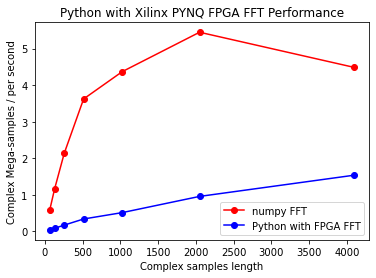

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([i[0] for i in sw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in sw_fft_times], 'r-o', label='numpy FFT')
ax.plot([i[0] for i in hw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in hw_fft_times], 'b-o', label='Python with FPGA FFT')
ax.set_xlabel('Complex samples length')
ax.set_ylabel('Complex Mega-samples / per second')
ax.legend()
ax.set_title('Python with Xilinx PYNQ FPGA FFT Performance');

## Benchmark the system: pre-buf DMA FFT vs Numpy FFT


1. use the example from the beginning but enhance it to use both the hardware and software versions of the FFT
1. this time use the SimpleDmaDriver.send_dma() and .rcv_dma() methods to transfer the data, resize the buffers properly before using those methods
1. enhance the program to use the AXI hardware timer for measurements
    1. use the timer to measure execution times of both the HW and Numpy FFT
1. collect the metrics for 100 runs of both Numpy and HW FFT and for each length from: 64 - 4096 in steps of powers of 2
1. compare HW vs Numpy FFT execution times
1. for the 4096 length hardware FFT, compare the fast DMA method vs. the Numpy performance in units of Complex Mega Samples per Second (samples/time)

In [14]:
sw_fft_times = []
hw_fft_times = []
tmr.start_tmr()
for i in range(6,max_fft_N+1):
    hwt = swt = 0
    size = 2 ** i
    fft.resize_bufs(size, dtype=np.complex64)
    din = np.empty(shape=(size,), dtype=np.complex64)
    fft.txbuf.imag[0:size] = np.random.rand(size,)
    fft.txbuf.real[0:size] = np.random.rand(size,)
    fft_cfg.send_tx_pkt(create_config_tdata(i, 1))
    for n in range(0,100):
        start = tmr.read_count()
        dout_sw = np.fft.fftn(fft.txbuf)
        end = tmr.read_count()
        swt += tmr.time_it(start,end)
        start = tmr.read_count()
        fft.send_dma()
        fft.rcv_dma()
        end = tmr.read_count()
        hwt += tmr.time_it(start,end)
    sw_fft_times.append([size, 1000*swt/(n+1)])
    hw_fft_times.append([size, 1000*hwt/(n+1)])
print('Times are in mS')
print(sw_fft_times)
print(hw_fft_times)
print('Acceleration factor:')
a = []
for i in range(0,len(hw_fft_times)):
    a.append([sw_fft_times[i][0], sw_fft_times[i][1]/hw_fft_times[i][1]])
print(a)
fft.txbuf.close()
fft.rxbuf.close()

Times are in mS
[[64, 0.1028043080430804], [128, 0.10903249032490331], [256, 0.13661016610166105], [512, 0.17830382303823036], [1024, 0.27713705137051364], [2048, 0.49851162511625113], [4096, 0.9950112701127007]]
[[64, 0.3773799337993378], [128, 0.37307237072370725], [256, 0.3716668766687665], [512, 0.36979909799098], [1024, 0.36939253392533933], [2048, 0.3747064670646705], [4096, 0.37455322553225523]]
Acceleration factor:
[[64, 0.2724159363961942], [128, 0.292255602079017], [256, 0.3675607773447336], [512, 0.4821640290820274], [1024, 0.750250819705327], [2048, 1.3304057146956398], [4096, 2.6565283710979917]]


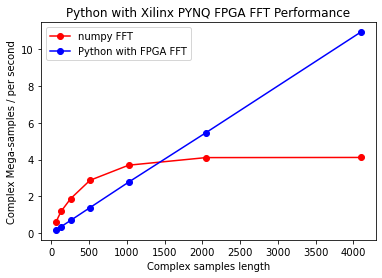

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
f, ax = plt.subplots()
ax.plot([i[0] for i in sw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in sw_fft_times], 'r-o', label='numpy FFT')
ax.plot([i[0] for i in hw_fft_times], [i[0]/(i[1] * .001) / 1e6 for i in hw_fft_times], 'b-o', label='Python with FPGA FFT')
ax.set_xlabel('Complex samples length')
ax.set_ylabel('Complex Mega-samples / per second')
ax.legend()
ax.set_title('Python with Xilinx PYNQ FPGA FFT Performance');

In [16]:
print('Complex Mega Samples/sec: ' + str(2**max_fft_N/(hw_fft_times[i][1] * .001) / 1e6))

Complex Mega Samples/sec: 10.935695438690773


In [17]:
print('Complex Mega Samples/sec: ' + str(2**max_fft_N/(sw_fft_times[i][1] * .001) / 1e6))

Complex Mega Samples/sec: 4.1165362876101526
